# <p style="text-align:center">EE 379K: Lab Five</p>
# <p style="text-align:center">Kyle Grier and Stefan Bordovsky</p>
#### <p style="text-align:center">Due: Monday, 10/09 3:00pm</p>

<p style="padding-left:40px">
    <b>Problem 3:</b> Problem 5 from Chapter 5 Estimating the test error of logistic regression using a
validation set.
<br>
<div style="padding-left:60px">5. In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.</div>
<div style="padding-left:80px">(a) Fit a logistic regression model that uses income and balance to predict default.</div>
</p>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rand
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

%matplotlib inline

default_data = pd.read_csv('./default.csv')
income_as_str = default_data.iloc[:, 4].values
income = map(float, income_as_str)
balance_as_str = default_data.iloc[:, 3].values
balance = map(float, balance_as_str)

default_data['defaulted'] = default_data['default'].map({'Yes': 1, 'No': 0})

default_data.head()


,Unnamed: 0,default,student,balance,income,defaulted
0,1,No,No,729.526495,44361.625074,0
1,2,No,Yes,817.180407,12106.134700,0
2,3,No,No,1073.549164,31767.138947,0
3,4,No,No,529.250605,35704.493935,0
4,5,No,No,785.655883,38463.495879,0


In [16]:
# Referencing http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
# create dataframes with an intercept column and columns for balance and income with a label column for dummy default variable.
y, X = dmatrices('defaulted ~ balance + income',
                  default_data, return_type="dataframe")

# Flatten y into a 1-D array by removing indices and leaving defaulted values.
y = np.ravel(y)

# Instantiate logistic regression.
model = LogisticRegression()
# Fit logistic regression using x, y.
model = model.fit(X, y)

# Accuracy on training set:
print model.score(X, y)

# y mean = percentage of people who defaulted.
y.mean()

# Coefficients computed by logistic regression:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

0.9664


,0,1
0,Intercept,[-1.94173062729e-06]
1,balance,[0.000407575689016]
2,income,[-0.000125881139749]


<p>
    <div style="padding-left:80px">
        (b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:
    </div>
    <div style="padding-left:100px">
        i. Split the sample set into a training set and a validation set.
    </div>
</p>

In [34]:
# Still referencing http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
# evaluate the model by splitting into train and test sets
X_training, X_validation, y_training, y_validation = train_test_split(X, y, test_size=0.3, random_state= rand.randint(0, 10000))

<p style="padding-left:100px">
    ii. Fit a multiple logistic regression model using only the training observations.
</p>

In [35]:
training_model = LogisticRegression()
training_model.fit(X_training, y_training)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<p style="padding-left:100px">
    iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.
</p>

In [36]:
# Predict default status for the validation set.
predicted = training_model.predict(X_validation)

# Generate posterior probabilities of default.
posterior_prob = training_model.predict_proba(X_validation)

<p style="padding-left:100px">
    iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.
</p>

In [37]:
# Validation set error = 1 - Validation set accuracy.
validation_set_error = 1 - metrics.accuracy_score(y_validation, predicted)
print(validation_set_error)

0.0313333333333


<p style="padding-left:80px">
    (c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.
</p>

In [58]:
X_training_sets = {}
X_validation_sets = {}
y_training_sets = {}
y_validation_sets = {}
training_model_sets = {}
predictions = {}
posterior_probs = {}
validation_set_errors = {}

for i in range(3):
    X_training_sets[i], X_validation_sets[i], y_training_sets[i], y_validation_sets[i] = train_test_split(X, y, test_size=0.30 * (1 + i), random_state=rand.randint(0, 10000))
    training_model_sets[i] = LogisticRegression()
    training_model_sets[i].fit(X_training_sets[i], y_training_sets[i])
    
    # Predict default status for the validation set.
    predictions[i] = training_model_sets[i].predict(X_validation_sets[i])

    # Generate posterior probabilities of default.
    posterior_probs[i] = training_model_sets[i].predict_proba(X_validation_sets[i])
    
    # Validation set error = 1 - Validation set accuracy.
    validation_set_errors[i] = 1 - metrics.accuracy_score(y_validation_sets[i], predictions[i])
    print("Validation set error for split " + str(i) + ": " + str(validation_set_errors[i]))

Validation set error for split 0: 0.0313333333333
Validation set error for split 1: 0.0375
Validation set error for split 2: 0.0335555555556


<p style="padding-left:100px">
    There is no apparent trend in validation set error dependent upon the ratio of test-set to training-set size upon running the above block of code.
</p>

<p style="padding-left:80px">
    (d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.
</p>

In [59]:
# Create a dummy variable for student.
default_data['dummy_student'] = default_data['student'].map({'Yes': 1, 'No': 0})

# Referencing http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
# create dataframes with an intercept column and columns for balance, income, and dummy student variable
y_DS, X_DS = dmatrices('defaulted ~ balance + income + dummy_student',
                  default_data, return_type="dataframe")

# Flatten y into a 1-D array by removing indices and leaving defaulted values.
y_DS = np.ravel(y_DS)

# Instantiate logistic regression.
model_DS = LogisticRegression()
# Fit logistic regression using x, y.
model_DS = model.fit(X_DS, y_DS)

# Still referencing http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
# Split model into train and test sets
X_training_DS, X_validation_DS, y_training_DS, y_validation_DS = train_test_split(X_DS, y_DS, test_size=0.3, random_state= rand.randint(0, 10000))

# Perform logistic regression on training sets.
training_model_DS = LogisticRegression()
training_model_DS.fit(X_training_DS, y_training_DS)

# Predict default status for the validation set.
predicted_DS = training_model_DS.predict(X_validation_DS)

# Generate posterior probabilities of default.
posterior_prob_DS = training_model_DS.predict_proba(X_validation_DS)

# Validation set error = 1 - Validation set accuracy.
validation_set_error_DS = 1 - metrics.accuracy_score(y_validation_DS, predicted_DS)
print("Validation set error for logistic regression with dummy student variable: " + str(validation_set_error_DS))

Validation set error for logistic regression with dummy student variable: 0.0326666666667


<p style="padding-left:100px">
    Adding a dummy variable for student status yields no obvious change in logistic regression results.
</p>

<p style="padding-left:40px">
<b>Problem 4:</b> Problem 8 from Chapter 5.(Cross Validation). Use Google or any other means to find the Python counterpart to R's rnorm.)
<br>
<div style="padding-left:60px">
    8. We will now perform cross-validation on a simulated data set.
</div>
<div style="padding-left:80px">
    (a) Generate a simulated data set as follows:
    <br>
</div>
<div style="padding-left:90px"> 
> set.seed(1)
<br>
> x=rnorm(100)
<br>
> y=x-2*x^2+rnorm (100)
<br>
</div>
<div style="padding-left:80px">
In this data set, what is n and what is p? Write out the model used to generate the data in equation form.
</div>
</p>

In [79]:
from sklearn import linear_model
import statsmodels.api as sm

np.random.seed(1)

n = 100
x = np.random.randn(n)
y = x - (2 * np.power(x, 2)) + np.random.randn(n)

/home/sbordovsky/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<p style="padding-left:100px">
    <i>(Referencing https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html)</i>
    <br>
    n for this data set is 100. p for the data set is 2.
    <br>
    The model for generating data used here is $y = x - 2x^2 + z$, where $x$ and $z$ are both arrays of size 100 generated from a gaussian distribution centered around mean 0 with standard deviation 1.
</p>

<p style="padding-left:80px">
    (b) Create a scatterplot of X against Y. Comment on what you find.
</p>

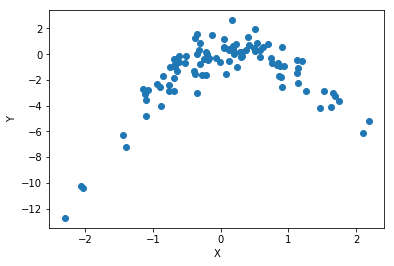

In [70]:
plt.plot(x, y, "o")
plt.xlabel("X")
plt.ylabel("Y")

<p style="padding-left:100px">
    The scatter plot of X vs Y resembles a parabola opening downwards, which reflects the $-2x^2$ term. It would resemble a parabolic arc exactly due to the x terms, but the z term adds noise to the function.
</p>

<p style="padding-left:80px">
    (c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:
</p>

In [95]:
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# Set random seed.
np.random.seed(7689)

n = 100
x_1 = np.random.randn(n)
y_1 = x_1 - (2 * np.power(x_1, 2)) + np.random.randn(n)

p_order = np.arange(1,5)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut(n)
scores = list()

# Find the Leave-One-Out Cross Validation error for polynomial model fits of order 1 to 4.
for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(x_1.reshape(-1, 1))
    score = cross_val_score(regr, X_poly, y_1, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score * -1)

#df = pd.DataFrame({'$x':x, '$y':y})
#df.columns = ['x', 'y']
#df.head()



<p style="padding-left:80px">
    <div style="padding-left:100px">
        i. $Y = β_0 + β_1X + \varepsilon$
    </div>
</p>

In [97]:
print("LOOCV error for this order 1 polynomial model: " + str(scores[0]))

LOOCV error for this order 1 polynomial model: 12.4657109716


<p style="padding-left:100px">
    ii. $Y = β_0 + β_1X + β_2X^2 + \varepsilon$
</p>

In [98]:
print("LOOCV error for this order 2 polynomial model: " + str(scores[1]))

LOOCV error for this order 2 polynomial model: 1.02525780466


<p style="padding-left:100px">
   iii. $Y = β_0 + β_1X + β_2X^2 + β_3X^3 + \varepsilon$
</p>

In [99]:
print("LOOCV error for this order 3 polynomial model: " + str(scores[2]))

LOOCV error for this order 3 polynomial model: 1.03946378452


<p style="padding-left:100px">
   iv. $Y = β_0 + β_1X + β_2X^2 + β_3X^3 + β_4X^4 + \varepsilon$ 
</p>

In [100]:
print("LOOCV error for this order 4 polynomial model: " + str(scores[3]))

LOOCV error for this order 4 polynomial model: 1.24138324237


<p style="padding-left:80px">
    Note you may find it helpful to use the data.frame() function to create a single data set containing both X and Y .
</p>

<p style="padding-left:80px">
    (d) Repeat (c) using another random seed, and report your results. Are your results the same as what you got in (c)? Why?
</p>

In [107]:
# Set random seed.
np.random.seed(2008)

n = 100
x_2 = np.random.randn(n)
y_2 = x_2 - (2 * np.power(x_2, 2)) + np.random.randn(n)

p_order = np.arange(1,5)

# LeaveOneOut CV
regr = skl_lm.LinearRegression()
loo = LeaveOneOut(n)
scores = list()

# Find the Leave-One-Out Cross Validation error for polynomial model fits of order 1 to 4.
for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(x_2.reshape(-1, 1))
    score = cross_val_score(regr, X_poly, y_2, cv=loo, scoring='neg_mean_squared_error').mean()
    scores.append(score * -1)
    print("LOOCV error for this order " + str(i) + " polynomial model: " + str(scores[i - 1]))

LOOCV error for this order 1 polynomial model: 8.81132146332
LOOCV error for this order 2 polynomial model: 0.901259442686
LOOCV error for this order 3 polynomial model: 1.03347868477
LOOCV error for this order 4 polynomial model: 1.17998727936


<p style="padding-left:100px">
    The LOOCV errors for both random seeds are different. This is because we changed the values of the noise data from the underlying model, resulting in slight variation in the data values we used for cross validation.
</p>

<p style="padding-left:80px">
    (e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer
</p>
<p style="padding-left:100px">
    The order 2 polynomial model had the smallest LOOCV error. This was expected given that the underlying data was built off of an order 2 polynomial model.
</p>

<p style="padding-left:80px">
    (f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?
</p>